In [1]:
pip install pandas numpy librosa scikit-learn joblib


In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
import kagglehub

# Dataset path (update based on your local path or downloaded kaggle location)
dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-song-audio")

# Feature extraction
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    return np.hstack([mfcc, chroma, contrast])

# Labels from filenames
def parse_label(file_name):
    parts = file_name.split('-')
    emotion_code = int(parts[2])
    emotion_dict = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry',
        6: 'fearful', 7: 'disgust', 8: 'surprised'
    }
    return emotion_dict[emotion_code]

# Extract features and labels
features = []
labels = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            try:
                feature = extract_features(path)
                label = parse_label(file)
                features.append(feature)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")

X = np.array(features)
y = np.array(labels)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Save model and encoder
joblib.dump(model, 'emotion_model.joblib')
joblib.dump(encoder, 'label_encoder.joblib')


              precision    recall  f1-score   support

       angry       1.00      0.97      0.99        72
        calm       0.95      1.00      0.97        77
     fearful       0.95      1.00      0.97        77
       happy       1.00      1.00      1.00        71
     neutral       1.00      1.00      1.00        38
         sad       1.00      0.91      0.96        70

    accuracy                           0.98       405
   macro avg       0.98      0.98      0.98       405
weighted avg       0.98      0.98      0.98       405



['label_encoder.joblib']

Model Accuracy: 98.02%


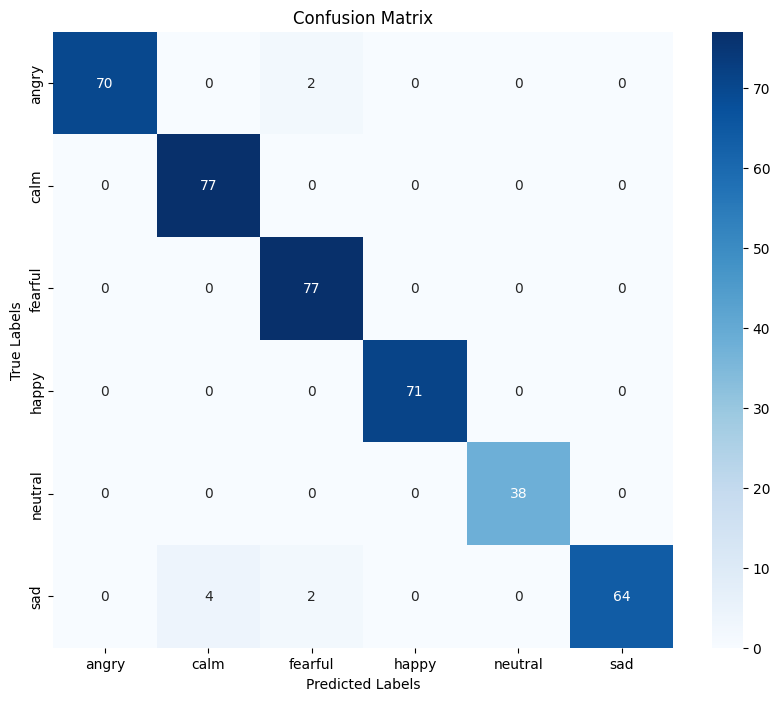

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {acc * 100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot class-wise prediction counts
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)
class_names = list(report.keys())[:-3]  # remove avg/total rows
precisions = [report[label]['precision'] for label in class_names]
recalls = [report[label]['recall'] for label in class_names]
f1_scores = [report[label]['f1-score'] for label in class_names]




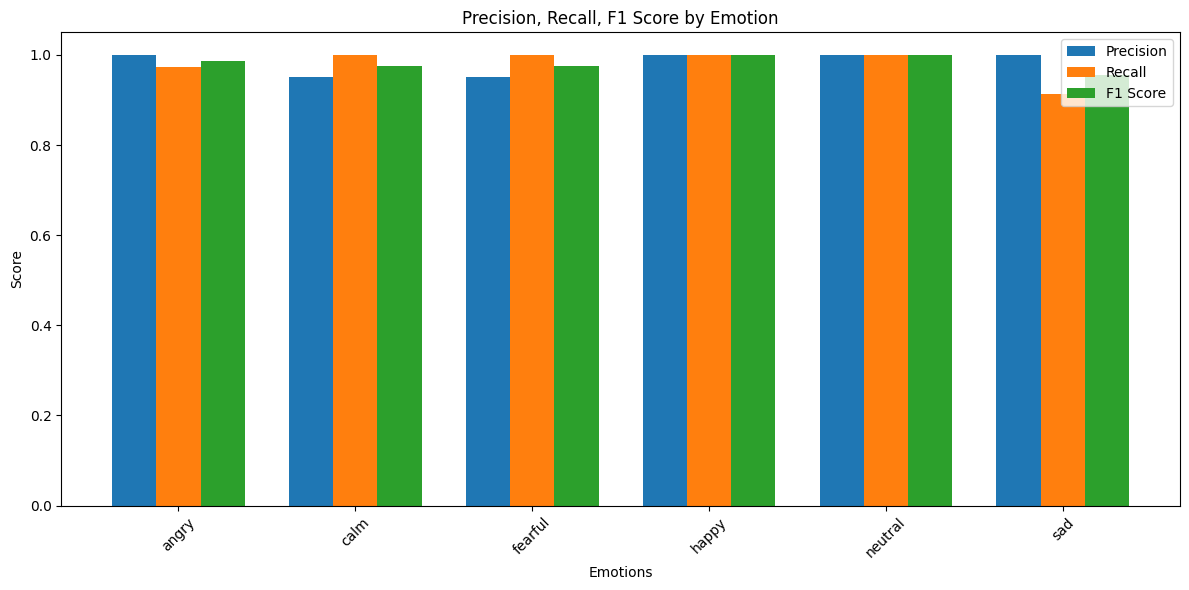

In [6]:
x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1_scores, width, label='F1 Score')

plt.xticks(x, class_names, rotation=45)
plt.xlabel('Emotions')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 Score by Emotion')
plt.legend()
plt.tight_layout()
plt.show()